## Вариант 1: первый бэктест (2 сделки)

- В расчёт попадает узкое окно данных — опционы за несколько дней до экспирации.
- Для открытия железного кондора требуются **полные данные** по всем 4 ногам:
  - есть цены опционов на всём периоде,
  - нет пропусков в IV и греках (`NaN` не допускаются).
- Если хотя бы у одной ноги не хватает данных, конструкция не строится.

Из-за жёстких фильтров подходящих наборов опционов оказалось всего два, поэтому стратегия открыла только **2 сделки**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

FILE_PATH = "btc_options_90d_3d_window_with_greeks.csv"

INITIAL_CAPITAL = 100_000
TP_PCT = 0.25
MAX_HOURS_IN_POSITION = 4
DELTA_SHORT = 0.20
DELTA_LONG = 0.05
DELTA_STOP = 0.35
RISK_FREE_RATE = 0.03

df = pd.read_csv(FILE_PATH)

df["time"] = pd.to_datetime(df["time"], utc=True)
df["expiration_timestamp"] = pd.to_datetime(df["expiration_timestamp"], utc=True)
df["expiration"] = df["expiration_timestamp"]

df = df.sort_values(["expiration", "time"]).reset_index(drop=True)


In [2]:
def select_iron_condor_legs(snapshot):
    snap = snapshot.dropna(subset=["delta"]).copy()
    calls = snap[snap["option_type"] == "call"]
    puts = snap[snap["option_type"] == "put"]
    if calls.empty or puts.empty:
        return None

    short_call_idx = (calls["delta"] - DELTA_SHORT).abs().idxmin()
    short_call = calls.loc[short_call_idx]

    long_call_candidates = calls[calls["strike"] > short_call["strike"]]
    if long_call_candidates.empty:
        long_call_candidates = calls[calls["delta"] < short_call["delta"]]
    if long_call_candidates.empty:
        return None
    long_call_idx = (long_call_candidates["delta"] - DELTA_LONG).abs().idxmin()
    long_call = long_call_candidates.loc[long_call_idx]

    short_put_idx = (puts["delta"] + DELTA_SHORT).abs().idxmin()
    short_put = puts.loc[short_put_idx]

    long_put_candidates = puts[puts["strike"] < short_put["strike"]]
    if long_put_candidates.empty:
        long_put_candidates = puts[puts["delta"] > short_put["delta"]]
    if long_put_candidates.empty:
        return None
    long_put_idx = (long_put_candidates["delta"] + DELTA_LONG).abs().idxmin()
    long_put = long_put_candidates.loc[long_put_idx]

    return {
        "call_short": short_call["instrument_name"],
        "call_long": long_call["instrument_name"],
        "put_short": short_put["instrument_name"],
        "put_long": long_put["instrument_name"],
        "expiration": short_call["expiration"],
    }


def iron_condor_price(snapshot, legs):
    snap = snapshot.set_index("instrument_name")
    try:
        cs = snap.loc[legs["call_short"]]
        cl = snap.loc[legs["call_long"]]
        ps = snap.loc[legs["put_short"]]
        pl = snap.loc[legs["put_long"]]
    except KeyError:
        return None

    if pd.isna(cs["mid_price"]) or pd.isna(cl["mid_price"]) or pd.isna(ps["mid_price"]) or pd.isna(pl["mid_price"]):
        return None

    call_spread = cs["mid_price"] - cl["mid_price"]
    put_spread = ps["mid_price"] - pl["mid_price"]
    price = call_spread + put_spread

    delta_cs = cs["delta"] if not pd.isna(cs["delta"]) else np.nan
    delta_ps = ps["delta"] if not pd.isna(ps["delta"]) else np.nan

    return {
        "price": price,
        "delta_call_short": delta_cs,
        "delta_put_short": delta_ps,
    }


def check_exit_conditions(entry_price, current_price, delta_call_short, delta_put_short, minutes_in_position):
    if current_price is None or np.isnan(current_price):
        return False, None

    if current_price <= entry_price * (1 - TP_PCT):
        return True, "tp"

    if minutes_in_position >= MAX_HOURS_IN_POSITION * 60:
        return True, "time"

    dc = abs(delta_call_short) if not np.isnan(delta_call_short) else 0.0
    dp = abs(delta_put_short) if not np.isnan(delta_put_short) else 0.0
    if max(dc, dp) >= DELTA_STOP:
        return True, "delta"

    return False, None


In [3]:
def simulate_trade(df, candidate):
    expiration = candidate["expiration"]
    entry_time = candidate["entry_time"]
    legs = candidate["legs"]
    entry_price = candidate["entry_price"]

    max_exit_time = min(entry_time + pd.Timedelta(hours=MAX_HOURS_IN_POSITION), expiration)

    times = (
        df.loc[
            (df["expiration"] == expiration)
            & (df["time"] >= entry_time)
            & (df["time"] <= max_exit_time),
            "time",
        ]
        .drop_duplicates()
        .sort_values()
    )

    if times.empty:
        return {
            "entry_time": entry_time,
            "exit_time": entry_time,
            "expiration": expiration,
            "entry_price": float(entry_price),
            "exit_price": float(entry_price),
            "pnl_pct": 0.0,
            "exit_reason": "no_data",
            "call_short": legs["call_short"],
            "call_long": legs["call_long"],
            "put_short": legs["put_short"],
            "put_long": legs["put_long"],
        }

    exit_time = entry_time
    exit_price = entry_price
    exit_reason = "time"

    for t in times:
        snapshot = df[(df["expiration"] == expiration) & (df["time"] == t)]
        price_info = iron_condor_price(snapshot, legs)
        if price_info is None:
            continue

        minutes_in_position = int((t - entry_time).total_seconds() // 60)
        should_exit, reason = check_exit_conditions(
            entry_price,
            price_info["price"],
            price_info["delta_call_short"],
            price_info["delta_put_short"],
            minutes_in_position,
        )

        exit_time = t
        exit_price = price_info["price"]

        if should_exit:
            exit_reason = reason
            break

    pnl_pct = (entry_price - exit_price) / entry_price if entry_price != 0 else 0.0

    return {
        "entry_time": entry_time,
        "exit_time": exit_time,
        "expiration": expiration,
        "entry_price": float(entry_price),
        "exit_price": float(exit_price),
        "pnl_pct": float(pnl_pct),
        "exit_reason": exit_reason,
        "call_short": legs["call_short"],
        "call_long": legs["call_long"],
        "put_short": legs["put_short"],
        "put_long": legs["put_long"],
    }


expirations = sorted(df["expiration"].unique())

candidates = []

for exp in expirations:
    entry_time = exp - pd.Timedelta(hours=6)
    snapshot = df[(df["expiration"] == exp) & (df["time"] == entry_time)]
    if snapshot.empty:
        continue

    legs = select_iron_condor_legs(snapshot)
    if legs is None:
        continue

    price_info = iron_condor_price(snapshot, legs)
    if price_info is None or price_info["price"] <= 0:
        continue

    candidates.append(
        {
            "expiration": exp,
            "entry_time": entry_time,
            "legs": legs,
            "entry_price": float(price_info["price"]),
        }
    )

candidates = sorted(candidates, key=lambda x: x["entry_time"])

trades = []
last_exit_time = None

for cand in candidates:
    if last_exit_time is not None and cand["entry_time"] < last_exit_time:
        continue
    trade = simulate_trade(df, cand)
    trades.append(trade)
    last_exit_time = trade["exit_time"]


,entry_time,exit_time,expiration,entry_price,exit_price,pnl_pct,exit_reason,call_short,call_long,put_short,put_long,equity
0,2025-11-23 02:00:00+00:00,2025-11-23 02:05:00+00:00,2025-11-23 08:00:00+00:00,0.0008,0.0006,0.25000,tp,BTC-23NOV25-87000-C,BTC-23NOV25-88000-C,BTC-23NOV25-84000-P,BTC-23NOV25-82000-P,125000.00
1,2025-11-24 02:00:00+00:00,2025-11-24 02:10:00+00:00,2025-11-24 08:00:00+00:00,0.0032,0.0039,-0.21875,delta,BTC-24NOV25-88000-C,BTC-24NOV25-90000-C,BTC-24NOV25-85000-P,BTC-24NOV25-83000-P,97656.25


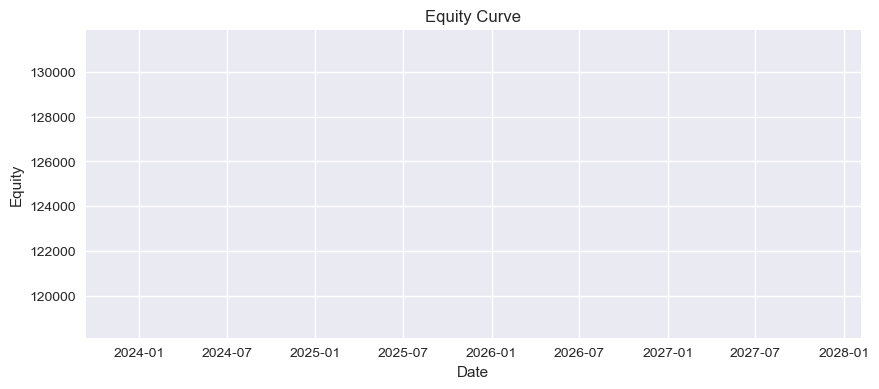

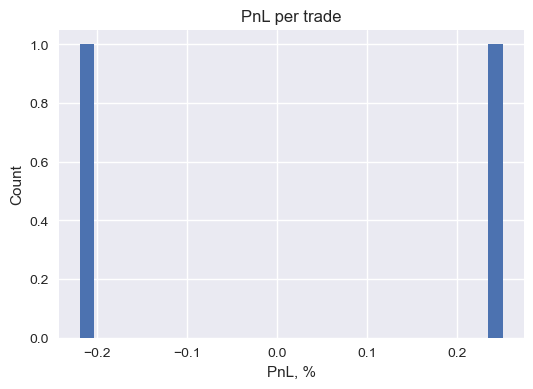

Total trades: 2
Total return: 0.25
Max drawdown: 0.0
Win rate: 0.5
Average win (pnl_pct): 0.25
Average loss (pnl_pct): -0.2187499999999999
Sharpe ratio (annualized): nan


In [4]:
trades_df = pd.DataFrame(trades)

if trades_df.empty:
    display(trades_df)
else:
    trades_df = trades_df.sort_values("entry_time").reset_index(drop=True)

    trades_df["equity"] = INITIAL_CAPITAL * (1 + trades_df["pnl_pct"]).cumprod()

    equity_points = pd.DataFrame(
        {
            "time": [trades_df["entry_time"].min()] + list(trades_df["exit_time"]),
            "equity": [INITIAL_CAPITAL] + list(trades_df["equity"]),
        }
    ).sort_values("time")

    equity_curve = (
        equity_points.set_index("time")
        .resample("1D")
        .ffill()
        .dropna()
    )

    equity_curve["cummax"] = equity_curve["equity"].cummax()
    equity_curve["drawdown"] = equity_curve["equity"] / equity_curve["cummax"] - 1
    max_drawdown = equity_curve["drawdown"].min()

    total_return = equity_curve["equity"].iloc[-1] / INITIAL_CAPITAL - 1

    num_trades = len(trades_df)
    wins = trades_df[trades_df["pnl_pct"] > 0]
    losses = trades_df[trades_df["pnl_pct"] < 0]

    win_rate = len(wins) / num_trades if num_trades > 0 else np.nan
    avg_win = wins["pnl_pct"].mean() if not wins.empty else np.nan
    avg_loss = losses["pnl_pct"].mean() if not losses.empty else np.nan

    returns = equity_curve["equity"].pct_change().dropna()
    if len(returns) > 1 and returns.std() > 0:
        rf_daily = (1 + RISK_FREE_RATE) ** (1 / 252) - 1
        excess = returns - rf_daily
        sharpe_ratio = np.sqrt(252) * excess.mean() / excess.std()
    else:
        sharpe_ratio = np.nan

    display(trades_df.head())

    plt.figure(figsize=(10, 4))
    plt.plot(equity_curve.index, equity_curve["equity"])
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(trades_df["pnl_pct"], bins=30)
    plt.title("PnL per trade")
    plt.xlabel("PnL, %")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

    print("Total trades:", num_trades)
    print("Total return:", total_return)
    print("Max drawdown:", max_drawdown)
    print("Win rate:", win_rate)
    print("Average win (pnl_pct):", avg_win)
    print("Average loss (pnl_pct):", avg_loss)
    print("Sharpe ratio (annualized):", sharpe_ratio)
